# Homework from Elena

In [93]:
import pandas as pd
import numpy as np
import numbers

#helper function to convert x to -log(x)

def convert_to_pki(affinities):               
	    """Returns value in new_min to new_max scale
	
	    Parameters
	    ----------
	    affinities : np.float32 or pd.DataFrame
	        value to convert (in nanomolar)
	
	    Returns
	    ----------
	    new_val : np.float32
	        new value as pKi
	    """
	
	    if isinstance(affinities, pd.DataFrame):
	        affinities = -np.log10(affinities)
	        affinities += 9
	    elif isinstance(affinities, np.ndarray):
	        nonzeros = np.nonzero(affinities)
	        affinities[nonzeros] = -np.log10(affinities[nonzeros])
	        affinities[nonzeros] += 9
	    elif isinstance(affinities, numbers.Number):
	        affinities = 9 - np.log10(affinities)
	    else:
	        raise TypeError("only numpy ndarray and pandas dataframe types are supported. {} was found"
	                        .format(type(affinities)))
	    return affinities


### 1. Read  an anonymous protein's binding data for a set of molecules

In [94]:
data = pd.read_csv("query_smiles_for_tc_train_anonymized.csv",sep='\t', index_col = 0)

data.insert(3, '-log(nm)', [convert_to_pki(affinities) for affinities in data['Activity']]) # convert avtivity to -log(nm)
data['binder'] = data['-log(nm)'] > 5.0   # molecules have -log(nM) bigger than 5.0 are considered as binders to the protein

data.head()

,Target,Molecule_ID,Activity,-log(nm),SMILES,binder
0,B,0,1.80,8.744727,CC(C)Oc1ccccc1N2CCN(Cc3cccc(c3)C(=O)N4CCCCC4)CC2,True
1,B,1,281.50,6.550522,Oc1ccccc1OCCNCc2ccccc2,True
2,B,2,83.00,7.080922,Oc1ccc2CCC3C(OCCN3CCc4cccs4)c2c1,True
3,B,3,27.80,7.555955,CS(=O)(=O)Nc1cc(OCCNCc2cccs2)ccc1Cl,True
4,B,4,0.21,9.677781,CCCN1CCOC2C1CCc3ccc(O)cc23,True


### 2. Generate ECFP fingerprints and calculate the Tanimoto Similarity

In [95]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

query_mol = Chem.MolFromSmiles('OC1(CCN(CCCC(=O)c2ccc(F)cc2)CC1)c3ccc(Cl)cc3') # construct query molecule using SMILES
data['Mols'] = [Chem.MolFromSmiles(s) for s in data['SMILES']] # construct given molecules usinf SMILES

radius = 2 
query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, radius, nBits = 1024) # generate ECFP 1024bit fingerprint for query molecule
data['Fingerprints'] = [AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits = 1024) for m in data['Mols']] # generate ECFP 1024bit fingerprint for given molecules

data['TanimotoSimilarity'] = [DataStructs.FingerprintSimilarity(query_fp, fp) for fp in fps] # calculate the Tanimoto Similarity(TS)

data.head()

,Target,Molecule_ID,Activity,-log(nm),SMILES,binder,Mols,Fingerprints,TanimotoSimilarity
0,B,0,1.80,8.744727,CC(C)Oc1ccccc1N2CCN(Cc3cccc(c3)C(=O)N4CCCCC4)CC2,True,<rdkit.Chem.rdchem.Mol object at 0x7f4855ac9ad0>,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.175000
1,B,1,281.50,6.550522,Oc1ccccc1OCCNCc2ccccc2,True,<rdkit.Chem.rdchem.Mol object at 0x7f4855ac9a30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.090909
2,B,2,83.00,7.080922,Oc1ccc2CCC3C(OCCN3CCc4cccs4)c2c1,True,<rdkit.Chem.rdchem.Mol object at 0x7f4855ac94e0>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.112500
3,B,3,27.80,7.555955,CS(=O)(=O)Nc1cc(OCCNCc2cccs2)ccc1Cl,True,<rdkit.Chem.rdchem.Mol object at 0x7f4855ac9530>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",0.085366
4,B,4,0.21,9.677781,CCCN1CCOC2C1CCc3ccc(O)cc23,True,<rdkit.Chem.rdchem.Mol object at 0x7f4855ac93f0>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.121622


### 3. Plot each molecule using the similarity to the query molecule (TS) as a function of Activity(-log(nm))

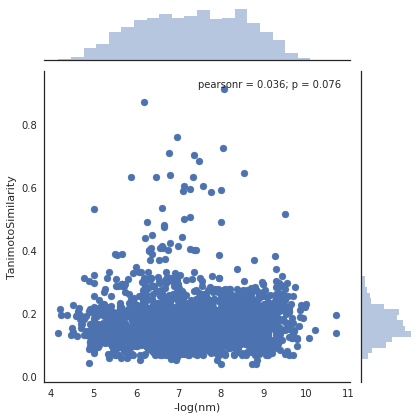

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.jointplot(x = '-log(nm)', y = 'TanimotoSimilarity', data = data) # plot: TS vs -log(nm)
plt.show()

Intuitively, the query molecule is more similiar to the molecules with higher -log(nm), so I think it can be considered as a binder to the protein

### 4. Train random forest and support vector machine classifier

4.1 Random Forest 

4.1.1 regressor:

In [97]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
rf_regressor.fit(list(data['Fingerprints']), data['-log(nm)'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [98]:
rf_regressor.predict([query_fp])

array([ 6.97609107])

4.1.2 classifier:

In [99]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf_classifier.fit(list(data['Fingerprints']), data['binder'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [100]:
rf_classifier.predict([query_fp])

array([ True], dtype=bool)

4.2 SVM:

4.2.1 regressor:

In [101]:
from sklearn import svm
svr_model = svm.SVR()
svr_model.fit(list(data['Fingerprints']), data['-log(nm)'])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [102]:
svr.predict([query_fp])

array([ 7.20508719])

4.2.2 classifier:

In [103]:
svc_model = svm.SVC()
svc_model.fit(list(data['Fingerprints']), data['binder'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [104]:
svc_model.predict([query_fp])

array([ True], dtype=bool)